# VHSE-Based Prediction of Proteasomal Cleavage Sites

`Xie J, Xu Z, Zhou S, Pan X, Cai S, Yang L, et al. (2013) The VHSE-Based Prediction of Proteasomal Cleavage Sites. PLoS ONE 8(9): e74506.` [doi:10.1371/journal.pone.0074506](https://dx.doi.org/10.1371%2Fjournal.pone.0074506)

**Abstract**: "Prediction of proteasomal cleavage sites has been a focus of computational biology. Up to date, the predictive methods are mostly based on nonlinear classifiers and variables with little physicochemical meanings. In this paper, the physicochemical properties of 14 residues both upstream and downstream of a cleavage site are characterized by VHSE (principal component score vector of hydrophobic, steric, and electronic properties) descriptors. Then, the resulting VHSE descriptors are employed to construct prediction models by support vector machine (SVM). For both in vivo and in vitro datasets, *the performance of VHSE-based method is comparatively better than that of the well-known [PAProC](http://www.paproc.de/), [MAPPP](http://www.mpiib-berlin.mpg.de/MAPPP/), and [NetChop](http://www.cbs.dtu.dk/Services/NetChop) methods*. The results reveal that the *hydrophobic property of 10 residues both upstream and downstream of the cleavage site is a dominant factor affecting in vivo and in vitro cleavage specificities*, followed by residue’s electronic and steric properties. Furthermore, the difference in hydrophobic potential between residues flanking the cleavage site is proposed to favor substrate cleavages. Overall, the interpretable VHSE-based method provides a preferable way to predict proteasomal cleavage sites."

Notes:

* Databases used in this study to create training and test sets
    * [Immune Epitope Database and Analysis Resource](http://www.iedb.org/)
    * [NCBI's reference sequence (RefSeq) database](http://www.ncbi.nlm.nih.gov/RefSeq/)
    * [AntiJen](http://www.ddg-pharmfac.net/antijen/AntiJen/antijenhomepage.htm) - a kinetic, thermodynamic and cellular database v2.0
    * [ExPASy/SWISS-PROT](http://www.expasy.org/)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.preprocessing import MinMaxScaler
# Note: in scikit 0.18, GridSearchCV is in 'model_selection'
from sklearn.grid_search import GridSearchCV
#pd.show_versions(as_json=False)


The principal component score **V**ector of **H**ydrophobic, **S**teric, and **E**lectronic properties (VHSE) is 
a set of amino acid descriptors that come from [A new set of amino acid descriptors and its application in peptide QSARs](http://onlinelibrary.wiley.com/doi/10.1002/bip.20296/abstract)

* VHSE1 and VHSE2 are related to hydrophobic (H) properties, 
* VHSE3 and VHSE4 to steric (S) properties, and 
* VHSE5 to VHSE8 to electronic (E) properties.

In [2]:
# (3-letter, VHSE1, VHSE2, VHSE3, VHSE4, VHSE5, VHSE6, VHSE7, VHSE8)
vhse = {
"A": ("Ala", 0.15, -1.11, -1.35, -0.92, 0.02, -0.91, 0.36, -0.48),
"R": ("Arg", -1.47, 1.45, 1.24, 1.27, 1.55, 1.47, 1.30, 0.83),
"N": ("Asn", -0.99, 0.00, -0.37, 0.69, -0.55, 0.85, 0.73, -0.80),
"D": ("Asp", -1.15, 0.67, -0.41, -0.01, -2.68, 1.31, 0.03, 0.56),
"C": ("Cys", 0.18, -1.67, -0.46, -0.21, 0.00, 1.20, -1.61, -0.19),
"Q": ("Gln", -0.96, 0.12, 0.18, 0.16, 0.09, 0.42, -0.20, -0.41),
"E": ("Glu", -1.18, 0.40, 0.10, 0.36, -2.16, -0.17, 0.91, 0.02),
"G": ("Gly", -0.20, -1.53, -2.63, 2.28, -0.53, -1.18, 2.01, -1.34),
"H": ("His", -0.43, -0.25, 0.37, 0.19, 0.51, 1.28, 0.93, 0.65),
"I": ("Ile", 1.27, -0.14, 0.30, -1.80, 0.30, -1.61, -0.16, -0.13),
"L": ("Leu", 1.36, 0.07, 0.26, -0.80, 0.22, -1.37, 0.08, -0.62),
"K": ("Lys", -1.17, 0.70, 0.70, 0.80, 1.64, 0.67, 1.63, 0.13),
"M": ("Met", 1.01, -0.53, 0.43, 0.00, 0.23, 0.10, -0.86, -0.68),
"F": ("Phe", 1.52, 0.61, 0.96, -0.16, 0.25, 0.28, -1.33, -0.20),
"P": ("Pro", 0.22, -0.17, -0.50, 0.05, -0.01, -1.34, -0.19, 3.56),
"S": ("Ser", -0.67, -0.86, -1.07, -0.41, -0.32, 0.27, -0.64, 0.11),
"T": ("Thr", -0.34, -0.51, -0.55, -1.06, 0.01, -0.01, -0.79, 0.39),
"W": ("Trp", 1.50, 2.06, 1.79, 0.75, 0.75, -0.13, -1.06, -0.85),
"Y": ("Tyr", 0.61, 1.60, 1.17, 0.73, 0.53, 0.25, -0.96, -0.52),
"V": ("Val", 0.76, -0.92, 0.17, -1.91, 0.22, -1.40, -0.24, -0.03)}


There were eight dataset used in this study. The reference datasets (s1, s3, s5, s7) were converted into the actual datasets used in the analysis (s2, s4, s6, s8) using the `vhse` vector. The s2 and s4 datasets were used for training the SVM model and the s6 and s8 were used for testing.

In [3]:
%ls data/proteasomal_cleavage

s1_in_vivo_mhc_1_antijen_swiss_prot_reference.csv
s2_in_vivo_mhc_1_antijen_swiss_prot_dataset.csv
s3_in_vitro_from_iedb_ncbi_reference.csv
s4_in_vitro_from_iedb_ncbi_dataset.csv
s5_in_vivo_mhc_1_ligands_reference.csv
s6_in_vivo_mhc_1_ligands_dataset.csv
s7_in_vitro_ssx2_hivnef_rui_reference.csv
s8_in_vitro_ssx2_hivnef_rui_dataset.csv


# In Vivo Data

The training set **Sequence** is the amino acid sequence (all of which are 28 amino acids long). The **Activity** column is '1' for the cleavage case (n=2607) and '-1' for the non-cleavage case (n=2480). There are 28 x 8 **VHSE** columns representing the eight VHSE scores for each amino acid in the polypeptide.

In [4]:
training_set = pd.DataFrame.from_csv("data/proteasomal_cleavage/s2_in_vivo_mhc_1_antijen_swiss_prot_dataset.csv")
training_set.head(5)

,Sequence,Name,Activity,VHSE11,VHSE12,VHSE13,VHSE14,VHSE15,VHSE16,VHSE17,...,VHSE277,VHSE278,VHSE281,VHSE282,VHSE283,VHSE284,VHSE285,VHSE286,VHSE287,VHSE288
0,AAAFCSAMYVGDLCGSVELVGQLFTFSP,cv-1,1,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,...,-0.64,0.11,0.22,-0.17,-0.50,0.05,-0.01,-1.34,-0.19,3.56
1,AACHKCIDFYSRIRELRHYSDSVYGDTL,cv-2,1,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,...,-0.79,0.39,1.36,0.07,0.26,-0.80,0.22,-1.37,0.08,-0.62
2,AACRAAGLQDCTMLVNGDDLVVICESAG,cv-3,1,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,...,0.36,-0.48,-0.20,-1.53,-2.63,2.28,-0.53,-1.18,2.01,-1.34
3,AAGIGILTVILGVLLLIGCWYCRRRNGY,cv-4,1,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,...,2.01,-1.34,0.61,1.60,1.17,0.73,0.53,0.25,-0.96,-0.52
4,AAIGLSMAGSSAMILAAYHPQQFIYAGS,cv-5,1,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,...,2.01,-1.34,-0.67,-0.86,-1.07,-0.41,-0.32,0.27,-0.64,0.11


## Training In Vivo Data

In [5]:
X_train_prescaled = training_set.loc[:,"VHSE11":"VHSE288"]
train_scaler = MinMaxScaler() # scale each feature 0-1
X_train = pd.DataFrame(train_scaler.fit_transform(X_train_prescaled))
y_train = training_set.Activity == 1

svr = svm.SVC()
# The authors state that "the optimal values of C, ε and γ are determined by the results 
# of 10-fold cross-validation." but they did not provide the parameters used.
parameters = {'kernel':['rbf'], 'C':[3, 10, 30, 100, 300], 'gamma':[0.01, 0.03, 0.1, 1, 3]}
# Use a 10-fold cv search with 8 threads
clf = GridSearchCV(svr, parameters, cv=10, n_jobs=8)

clf.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'kernel': ['rbf'], 'C': [3, 10, 30, 100, 300], 'gamma': [0.01, 0.03, 0.1, 1, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [6]:
print("The best parameters are %s with a score of %0.2f"
      % (clf.best_params_, clf.best_score_))


The best parameters are {'kernel': 'rbf', 'C': 30, 'gamma': 0.1} with a score of 0.80


## Testing In Vivo SVM Model

In [7]:
testing_set = pd.DataFrame.from_csv("data/proteasomal_cleavage/s6_in_vivo_mhc_1_ligands_dataset.csv")
X_test_prescaled = testing_set.loc[:, "VHSE11":"VHSE288"]
test_scaler = MinMaxScaler()
X_test = pd.DataFrame(test_scaler.fit_transform(X_test_prescaled))
y_test = testing_set.Activity == 1

y_predicted = clf.predict(X_test)

<IPython.core.display.Javascript object>


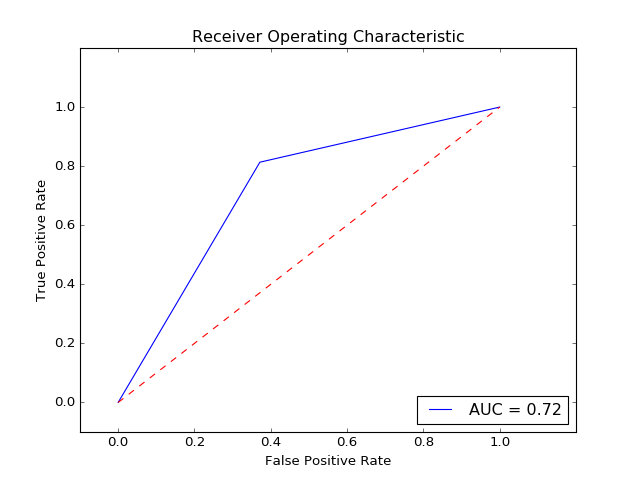

In [8]:
# Print ROC curves
%matplotlib notebook

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, pos_label=True)
roc_auc = metrics.roc_auc_score(y_test, y_predicted, average='macro', sample_weight=None)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()